### imports

In [ ]:
from cmath import e
from time import time
import cv2
import numpy as np
# from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy as Entropy
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
import os
import pandas as pd
import numpy as np
import argparse

### program arguments

In [ ]:
dir="E:/CMP/NN/project"
hingeDir=dir+"/Gold_Hinge/FeaturesOutput/hinge_features.npy"
goldDir=dir+"/Gold_Hinge/FeaturesOutput/cold_features.npy"
labelsDir=dir+"/Gold_Hinge/FeaturesOutput/labels.npz"

In [ ]:
X_hinge=np.load(hingeDir)
X_gold=np.load(goldDir)
Y=np.load(labelsDir)['label']
label_names=np.load(labelsDir)['label_name']

In [ ]:
df = pd.read_csv('train_answers.csv')
icdar_classes = df['male'].values

In [ ]:
# idx=label_names=='icdarTrainImages'
# Y[idx]=icdar_classes[int(Y[idx])]

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_hinge, Y, test_size=0.2, random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(np.concatenate((X_gold,X_hinge),axis=1), Y, test_size=0.2, random_state=1)
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)   

In [ ]:
def getBestParamsForSVM(X_train,Y_train,X_test,Y_test):
    scaler = preprocessing.MinMaxScaler().fit(X_train)
    C = [ 0.01, 0.1, 1, 10, 100,1000]
    gamma = [0.0001,0.001, 0.01, 0.1, 1,'scale']
    kernel = ['linear','rbf']
    scores = []
    scores_train = []
    
    with open('svm_results0.csv','w') as csvfile:
        np.savetxt(csvfile, [], delimiter=',',
                   header='C,gamma,kernel,score_train,score')
    for i in range(len(C)):
        for j in range(len(gamma)):
            for k in range(len(kernel)):
                clf = SVC(C=C[i], gamma=gamma[j],kernel=kernel[k],class_weight='balanced')
                clf.fit(scaler.transform( X_train), Y_train)
                temp_train = clf.score(scaler.transform(X_train), Y_train)
                print("Accuracy on training set: {:.2f}".format(
                    temp_train))    
                scores_train.append((temp_train,i,j))
                temp = clf.score(scaler.transform( X_test), Y_test)
                print("Accuracy on test set: {:.4f}".format(
                    temp))
                scores.append((temp,i,j))
                with open('svm_results0.csv', 'a') as csvfile:
                    np.savetxt(csvfile, np.array([[C[i],gamma[j],kernel[k],temp_train,temp]]), delimiter=',',fmt='%s')
        
    print(max(scores))
    print(max(scores_train))

In [ ]:
# getBestParamsForSVM(X_train,Y_train,X_test,Y_test)
# getBestParamsForSVM(X_train[:,np.arange(0,421)],Y_train,X_test[:,np.arange(0,421)],Y_test)
# getBestParamsForSVM(X_train[:,np.arange(421,1200)],Y_train,X_test[:,np.arange(421,1200)],Y_test)
# getBestParamsForANN(X_train,Y_train,X_test,Y_test)

In [64]:
# Classifier for gold features
scaler = preprocessing.MinMaxScaler().fit(X_train[:,np.arange(0,421)])
clf = SVC(C=1, gamma=0.001,kernel='linear',class_weight='balanced',random_state=1)
X = scaler.transform(X_train[:,np.arange(0,421)])
clf.fit(scaler.transform(X_train[:,np.arange(0,421)]), Y_train)
df_gold = clf.decision_function(scaler.transform(X_test[:,np.arange(0,421)]))
score_test_gold = clf.score(scaler.transform( X_test[:,np.arange(0,421)]), Y_test)
print("Accuracy on test set: {:.4f}".format(
    score_test_gold))
score_train_gold = clf.score(scaler.transform( X_train[:,np.arange(0,421)]), Y_train)
print("Accuracy on training set: {:.4f}".format(
    score_train_gold))


Accuracy on test set: 0.7397
Accuracy on training set: 0.8897


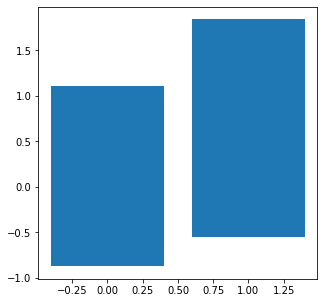

Accuracy on test set: 0.8356
Accuracy on training set: 1.0000


In [124]:
# Classifier for gold features
scaler = preprocessing.MinMaxScaler().fit(X_train[:,np.arange(421,1200)])
clf = SVC(C=10, gamma='scale',kernel='rbf',class_weight='balanced',random_state=1)
clf.fit(scaler.transform(X_train[:,np.arange(421,1200)]), Y_train)
df_hinge = clf.decision_function(scaler.transform(X_test[:,np.arange(421,1200)]))




score_test_hinge = clf.score(scaler.transform( X_test[:,np.arange(421,1200)]), Y_test)
print("Accuracy on test set: {:.4f}".format(
    score_test_hinge))
score_train_hinge = clf.score(scaler.transform( X_train[:,np.arange(421,1200)]), Y_train)
print("Accuracy on training set: {:.4f}".format(
    score_train_hinge))


In [140]:
# using the decision function
df = []
for i in range(len(df_gold)):
    df.append(max(df_gold[i],df_hinge[i]))

df = np.array(df)

predict = np.where(df>=0,1,0)
accuracy = accuracy_score(Y_test, predict)
print("Accuracy on test set: {:.4f}".format(
    accuracy))

Accuracy on test set: 0.7808


In [138]:
# classifier for both
scaler = preprocessing.MinMaxScaler().fit(X_train)
clf = SVC(C=10, gamma='scale',kernel='rbf',class_weight='balanced',random_state=1)
clf.fit(scaler.transform(X_train), Y_train)

score_test_both = clf.score(scaler.transform( X_test), Y_test)
print("Accuracy on test set: {:.4f}".format(
    score_test_both))
score_train_both = clf.score(scaler.transform( X_train), Y_train)
print("Accuracy on training set: {:.4f}".format(
    score_train_both))

Accuracy on test set: 0.8082
Accuracy on training set: 1.0000


In [ ]:
cs = preprocessing.MinMaxScaler().fit(X_train)
X_train = cs.transform(X_train) 
X_train = np.nan_to_num(X_train)

X_test = cs.transform(X_test) 
X_test = np.nan_to_num(X_test)

clf = SVC(kernel='rbf', verbose=True, C=10)
clf.fit(X_train, Y_train)
# print(clf.predict(X_test))
print(clf.score(X_test,Y_test))

In [ ]:
cs = preprocessing.MinMaxScaler()
X = cs.fit_transform(X_hinge) 
X = np.nan_to_num(X)
clf = SVC(kernel='rbf', verbose=True, C=10)
scores = cross_val_score(clf, X, Y, cv=10)
print(scores)
y_pred_hinge = cross_val_predict(clf, X, Y, cv=10)
# print(y_pred_hinge)

In [ ]:
cs = preprocessing.MinMaxScaler()
X = cs.fit_transform(X_gold)
X = np.nan_to_num(X)
clf = SVC(kernel='rbf', verbose=True, C=10)
scores = cross_val_score(clf, X, Y, cv=10)
print(scores)
y_pred_cold = cross_val_predict(clf, X, Y, cv=10)
print(y_pred_cold)

In [ ]:
y_pred = np.maximum(y_pred_hinge, y_pred_cold)

In [ ]:
print(sum(y_pred_hinge == Y) / float(len(Y)))